In [1]:
# Base 
# -----------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Missing Values 
# -----------------------------------
# !pip install missingno
import missingno as msno

# Models 
# -----------------------------------
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics & Evaluation
# -----------------------------------
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

- <code>survival</code> - **Target** (0 = No, 1 = Yes)
- <code>pclass</code> - **Ticket class** (1 = 1st, 2 = 2nd, 3 = 3rd)
- <code>sex</code> - **Sex**
- <code>Age</code> - **Age in years**
- <code>sibsp</code> - **# of siblings / spouses aboard the Titanic**	
- <code>parch</code> - **# of parents / children aboard the Titanic**	
- <code>ticket</code> - **Ticket number**
- <code>fare</code> - **Passenger fare**	
- <code>cabin</code> - **Cabin number**
- <code>embarked</code> - **Port of Embarkation**	(C = Cherbourg, Q = Queenstown, S = Southampton)

In [2]:
tr = pd.read_csv("../input/titanic/train.csv")
ts = pd.read_csv("../input/titanic/test.csv")

df = tr.append(ts)


for i in ["object", "float", "integer", "bool"]:
    print(i.capitalize()+" Variables:", "\n", "# of Variables:", 
      len(df.select_dtypes(i).columns), "\n", 
      df.select_dtypes(i).columns.tolist(), "\n")

df.shape, tr.shape, ts.shape

Object Variables: 
 # of Variables: 5 
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] 

Float Variables: 
 # of Variables: 3 
 ['Survived', 'Age', 'Fare'] 

Integer Variables: 
 # of Variables: 4 
 ['PassengerId', 'Pclass', 'SibSp', 'Parch'] 

Bool Variables: 
 # of Variables: 0 
 [] 



((1309, 12), (891, 12), (418, 11))

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0000,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0000,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C85,C
2,3,1.0000,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,C123,S
4,5,0.0000,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,NaN,S


In [4]:
df.describe([0.01, 0.05, 0.10, 0.80, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,50%,80%,90%,95%,99%,max
PassengerId,1309.0000,655.0000,378.0201,1.0000,14.0800,66.4000,131.8000,655.0000,1047.4000,1178.2000,1243.6000,1295.9200,1309.0000
Survived,891.0000,0.3838,0.4866,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Pclass,1309.0000,2.2949,0.8378,1.0000,1.0000,1.0000,1.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000
Age,1046.0000,29.8811,14.4135,0.1700,0.9200,5.0000,14.0000,28.0000,42.0000,50.0000,57.0000,65.0000,80.0000
SibSp,1309.0000,0.4989,1.0417,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,2.0000,5.0000,8.0000
Parch,1309.0000,0.3850,0.8656,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,2.0000,4.0000,9.0000
Fare,1308.0000,33.2955,51.7587,0.0000,0.0000,7.2250,7.5675,14.4542,41.5792,78.0508,133.6500,262.3750,512.3292


In [5]:
print(df.Survived.value_counts()), print(df.Survived.value_counts() / df.shape[0])

0.0000    549
1.0000    342
Name: Survived, dtype: int64
0.0000   0.4194
1.0000   0.2613
Name: Survived, dtype: float64


(None, None)

In [6]:
df.isnull().values.any()

True

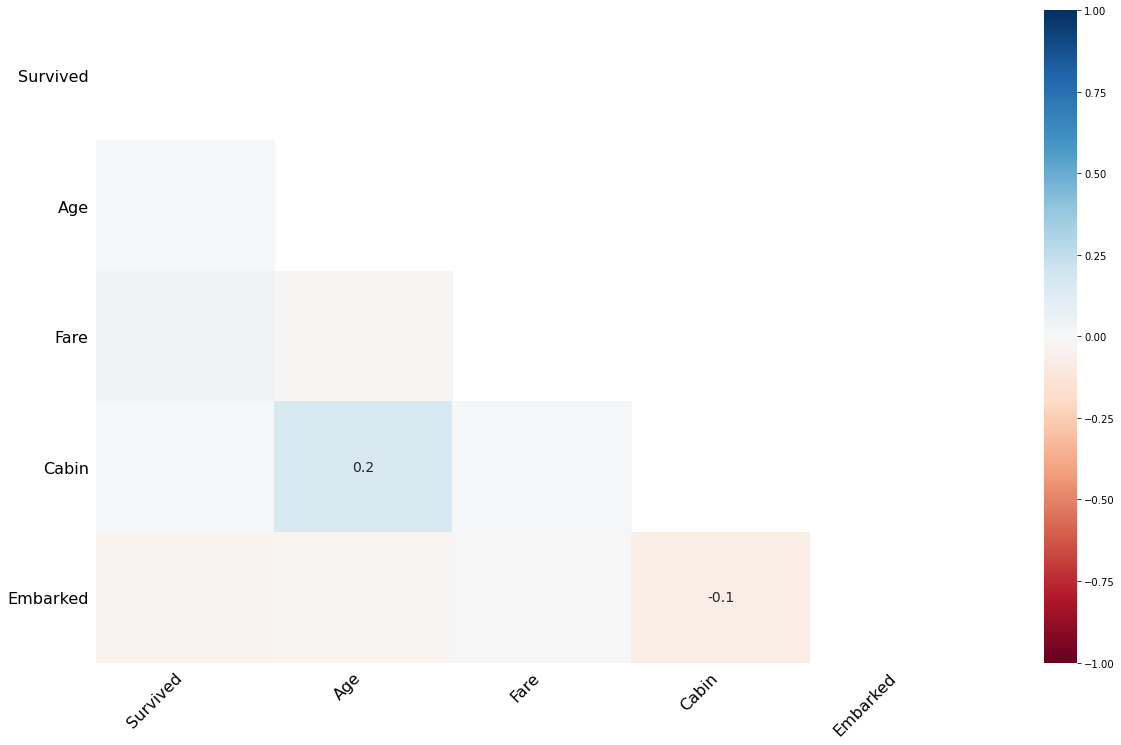

In [7]:
msno.heatmap(df)
plt.show()

Number of Variables include Missing Values: 4 

    Feature  Num_Missing  Missing_Ratio DataTypes
0     Cabin         1014         0.7746    object
2       Age          263         0.2009   float64
3  Embarked            2         0.0015    object
4      Fare            1         0.0008   float64 



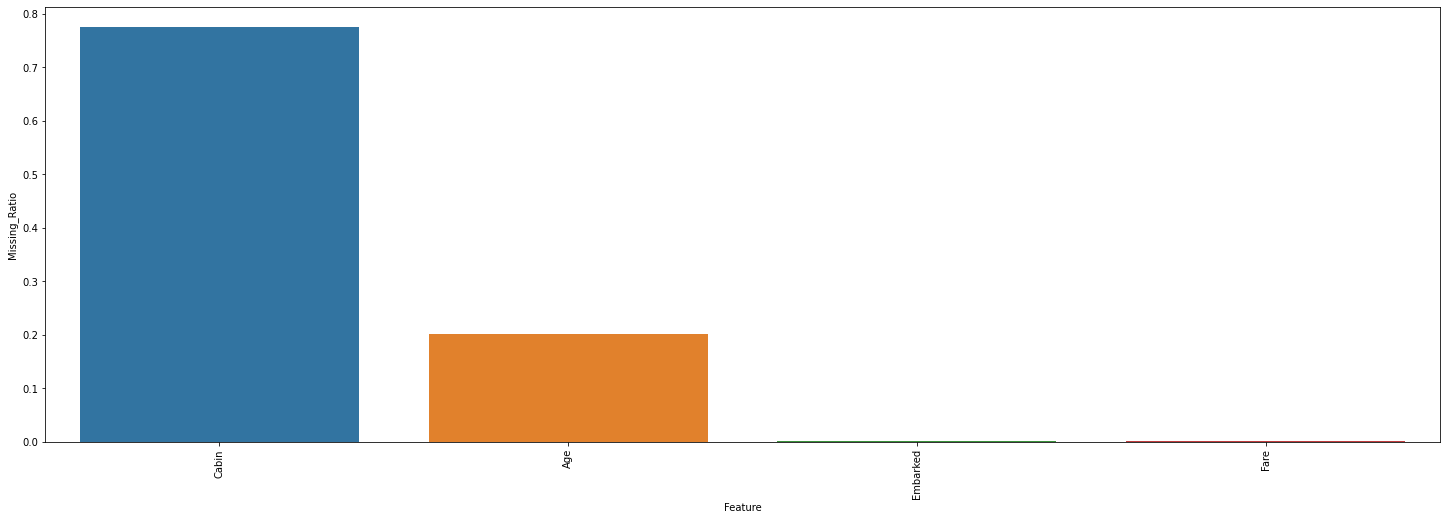

In [8]:
def missing_values(data, plot = False, target = "SalePrice"):
    
    mst = pd.DataFrame({"Num_Missing":df.isnull().sum(), "Missing_Ratio":df.isnull().sum() / df.shape[0]}).sort_values("Num_Missing", ascending = False)
    mst["DataTypes"] = df[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index":"Feature"}, axis = 1)
    mst = mst[mst.Feature != target]
    
    print("Number of Variables include Missing Values:", mst.shape[0], "\n")
    
    if mst[mst.Missing_Ratio > 0.99].shape[0] > 0:  
        print("Full Missing Variables:",mst[mst.Missing_Ratio > 0.99].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio > 0.99].Feature.tolist(), axis = 1, inplace = True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize = (25, 8))    
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
                        
    print(mst, "\n")        
    
missing_values(df, plot = True, target = "Survived")

In [9]:
def missing_vs_target(dataframe, target):
    temp_df = dataframe.copy()
    
    variable_with_na = temp_df.drop(target, axis = 1).isnull().sum().reset_index()
    variable_with_na = variable_with_na[variable_with_na[0] > 0]["index"].tolist()

    for variable in variable_with_na:
        temp_df[variable + '_NA_FLAG'] = np.where(temp_df[variable].isnull(), 1, 0)

    flags_na = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for variable in flags_na:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(variable)[target].mean()}), end="\n\n\n")

        
missing_vs_target(df, "Survived")

             TARGET_MEAN
Age_NA_FLAG             
0                 0.4062
1                 0.2938


              TARGET_MEAN
Fare_NA_FLAG             
0                  0.3838
1                     nan


               TARGET_MEAN
Cabin_NA_FLAG             
0                   0.6667
1                   0.2999


                  TARGET_MEAN
Embarked_NA_FLAG             
0                      0.3825
1                      1.0000




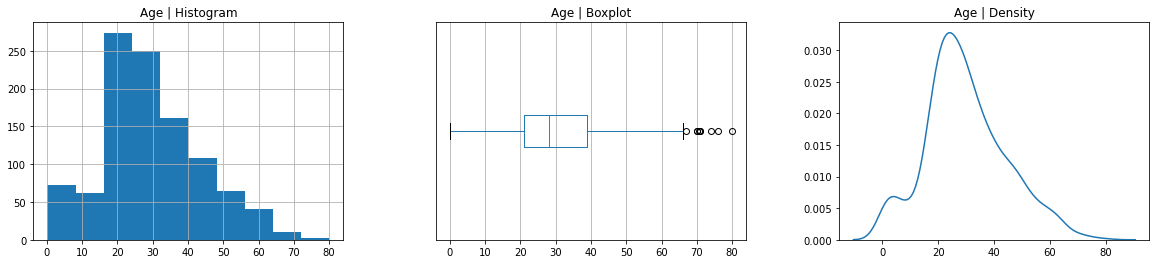

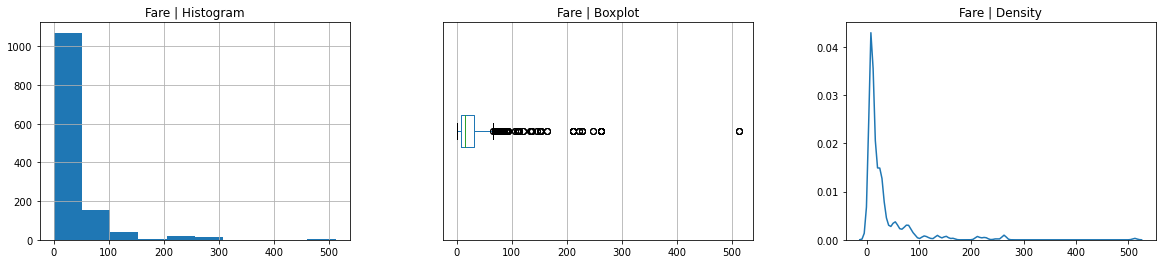

In [10]:
def num_plot(data, cat_length = 16, remove = ["Id"], hist_bins = 12, figsize = (20,4)):
    
    num_cols = [col for col in data.columns if data[col].dtypes != "O" 
                and len(data[col].unique()) >= cat_length]
    
    if len(remove) > 0:
        num_cols = list(set(num_cols).difference(remove))
            
    for i in num_cols:
        fig, axes = plt.subplots(1, 3, figsize = figsize)
        data.hist(str(i), bins = hist_bins, ax=axes[0])
        data.boxplot(str(i),  ax=axes[1], vert=False);
        try: 
            sns.kdeplot(np.array(data[str(i)]))
        except: ValueError
        
        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()
        
        
num_plot(df, cat_length = 16, remove = ["PassengerId"], hist_bins = 10, figsize = (20,4))

In [11]:
def cat_eda(data, cat_length, target = "Survived"):  
    dataframe = data.copy()
    
    #if len(ordinal_variable) > 0:
    #    dataframe.drop(ordinal_variable, axis = 1, inplace = True)
        
    more_cat_cols = [col for col in dataframe.columns if len(dataframe[col].unique()) < cat_length]
    
    num_cols = [col for col in data.columns if data[col].dtypes != "O" 
                and len(data[col].unique()) >= cat_length]
    
    for i in more_cat_cols: 
        print(i, ":", len(dataframe[i].value_counts()), "Unique Category -", str(dataframe[i].dtype))
        print(pd.DataFrame({"COUNT": dataframe[i].value_counts(),
                            "RATIO": dataframe[i].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(i)[target].mean(),
                            "TARGET_COUNT": dataframe.groupby(i)[target].count(),
                            "TARGET_STD": dataframe.groupby(i)[target].std()}), end="\n\n\n")
    
    print("# DTYPES -----------------------------")
    print("Object Variables:",dataframe[more_cat_cols].select_dtypes("object").columns.tolist(), "\n")
    print("Integer Variables:",dataframe[more_cat_cols].select_dtypes("integer").columns.tolist(), "\n")
    print("Float Variables:",dataframe[more_cat_cols].select_dtypes("float").columns.tolist(), "\n")
    
    print("# OTHER -----------------------------")
    print("More than " + str(cat_length)+" categories:", dataframe.drop(more_cat_cols + num_cols, axis = 1).columns, "\n")
    print(dataframe.drop(more_cat_cols + num_cols, axis = 1).nunique())

cat_eda(df, cat_length=10, target = "Survived")


Survived : 2 Unique Category - float64
        COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
0.0000    549 0.4194       0.0000           549      0.0000
1.0000    342 0.2613       1.0000           342      0.0000


Pclass : 3 Unique Category - int64
   COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
1    323 0.2468       0.6296           216      0.4840
2    277 0.2116       0.4728           184      0.5006
3    709 0.5416       0.2424           491      0.4289


Sex : 2 Unique Category - object
        COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
female    466 0.3560       0.7420           314      0.4382
male      843 0.6440       0.1889           577      0.3918


SibSp : 7 Unique Category - int64
   COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
0    891 0.6807       0.3454           608      0.4759
1    319 0.2437       0.5359           209      0.4999
2     42 0.0321       0.4643            28      0.5079
3     20 0.0153       0.2500            16      0.447

In [12]:
df[(df.Embarked.isnull()) | (df.Ticket == "113572")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0000,1,"Icard, Miss. Amelie",female,38.0000,0,0,113572,80.0000,B28,NaN
829,830,1.0000,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0000,0,0,113572,80.0000,B28,NaN


In [13]:
df[(df.Fare.isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,nan,3,"Storey, Mr. Thomas",male,60.5000,0,0,3701,nan,NaN,S


In [14]:
# Mode: S
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# All data median = 14, Pclass = 3 median = 8
df["Fare"] = df["Fare"].fillna(df.groupby("Pclass")["Fare"].transform("median"))


# Title
df['NEW_TITLE'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# Fill NA with Title
df["Age"] = df["Age"].fillna(df.groupby("NEW_TITLE")["Age"].transform("mean"))

In [15]:
# Label
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')

# Family
df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = 0
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = 1

# NUMERIC TO CATEGORICAL
df.loc[(df['Age'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['Age'] >= 18) & (df['Age'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['Age'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df["AGECAT2"] = pd.cut(df.Age, 8, labels = np.arange(1,9,1)).astype(int)

# INTERACTIONS

df["FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1
df["NEW_AGExPCLASS"] = df["Age"] * df["Pclass"]

df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['Sex'] == 'male') & ((df['Age'] > 21) & (df['Age']) < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['Sex'] == 'male') & (df['Age'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['Sex'] == 'female') & ((df['Age'] > 21) & (df['Age']) < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'


# PERSONNEL
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')

# CABIN CODE
cabin = []
import re
for i in range(0,len(df)):
    regex = re.compile('[A-Z]')
    try:
        temp = regex.findall(df.Cabin.iloc[i])[0]   
    except:
        temp = "Unknown"
    cabin.append(temp)
df["CabinCode"] = cabin


# FARE
df["Fare_0"] = np.where(df.Fare < 1, 1, 0)

df["FareClass"]= pd.cut(df.Fare, 10, labels = np.arange(1,11,1)).astype(int)

# Pclass / Fare
df["NewClass"] = df.Pclass / (df.Fare + 1)


# DROP
df.drop(["Name"], axis = 1, inplace = True)


df["Cabin"] = df.Cabin.fillna("Unknown")

In [16]:
# LABEL ENCODER
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in ["Sex", "Ticket", "Cabin", "CabinCode"]:
    df[i] = le.fit_transform(df[i])
    
# ONE-HOT ENCODER
df = pd.get_dummies(df, columns=["Embarked", "Pclass","NEW_TITLE", "NEW_AGE_CAT", "NEW_SEX_CAT"], drop_first=True)

In [17]:
cat_eda(df, cat_length=10, target = "Survived")

Survived : 2 Unique Category - float64
        COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
0.0000    549 0.4194       0.0000           549      0.0000
1.0000    342 0.2613       1.0000           342      0.0000


Sex : 2 Unique Category - int64
   COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
0    466 0.3560       0.7420           314      0.4382
1    843 0.6440       0.1889           577      0.3918


SibSp : 7 Unique Category - int64
   COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
0    891 0.6807       0.3454           608      0.4759
1    319 0.2437       0.5359           209      0.4999
2     42 0.0321       0.4643            28      0.5079
3     20 0.0153       0.2500            16      0.4472
4     22 0.0168       0.1667            18      0.3835
5      6 0.0046       0.0000             5      0.0000
8      9 0.0069       0.0000             7      0.0000


Parch : 8 Unique Category - int64
   COUNT  RATIO  TARGET_MEAN  TARGET_COUNT  TARGET_STD
0   1002 0.7655

# Algorithm Comparison
-----------------------------------------
LR: 0.813695 (0.033384)
NBAYES: 0.798052 (0.051104)
KNN: 0.713820 (0.050957)
CART: 0.792422 (0.044980)
BAGGING: 0.829438 (0.031484)
RF: 0.831673 (0.032424)
SVM: 0.661061 (0.052360)
ADAB: 0.822684 (0.039753)
GBM: 0.844032 (0.030927)
XGB: 0.830549 (0.028913)
LGBM: 0.831710 (0.035142)




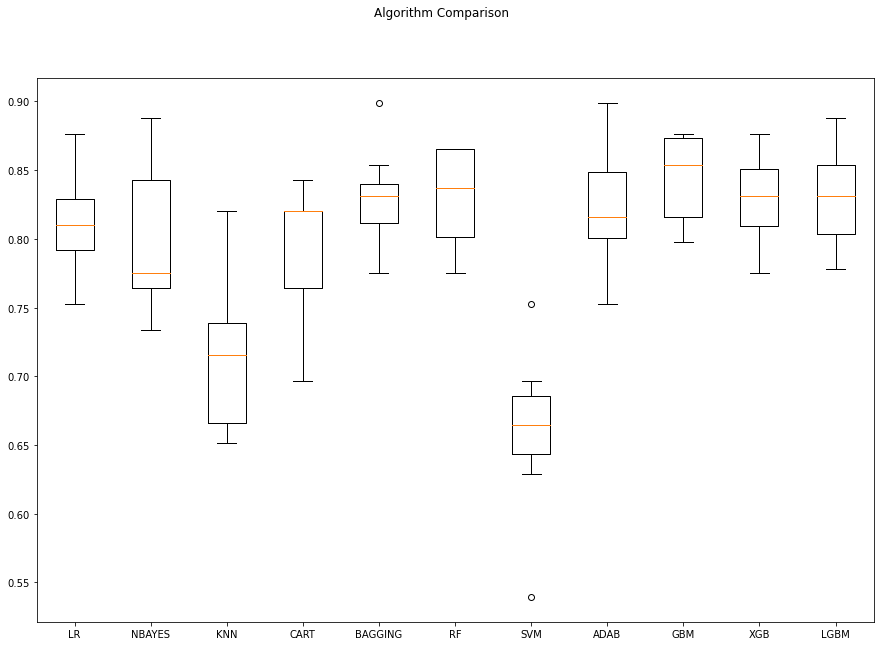

In [18]:
# Train Test Split After Data Manipulation
train = df.iloc[:891]
train["Survived"] = train["Survived"].astype("int")
train.drop("PassengerId", axis = 1, inplace = True)

test = df.iloc[891:].drop("Survived", axis = 1)

X_train = train.drop("Survived", axis = 1)
y_train = train.Survived


# All Models & Train Validation Scores
models = [('LR', LogisticRegression()),
          ("NBAYES", GaussianNB()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ("BAGGING", BaggingClassifier()),
          ('RF', RandomForestClassifier()),
          ('SVM', SVC(gamma='auto')),
          ("ADAB",AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGB", XGBClassifier()),
          ("LGBM", LGBMClassifier())]

# evaluate each model in turn
results = []
names = []

print("# Algorithm Comparison")
print("-----------------------------------------")
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
print("\n")    

# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [19]:
gbm = GradientBoostingClassifier(
    random_state=1
)
gbm

GradientBoostingClassifier(random_state=1)

In [20]:
params = {
    #"ccp_alpha":np.arange(0.0, 1.1, 0.1),
    "max_depth":np.arange(3, 16, 1),
    "max_leaf_nodes":np.arange(2, 11, 1)
}


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

gs = GridSearchCV(gbm, params,  n_jobs=-1, cv = 10, scoring = "accuracy")
gs_gbm = gs.fit(X_train, y_train)

gs_gbm

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy')

In [21]:
print(classification_report(y_train, gs_gbm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       549
           1       0.94      0.90      0.92       342

    accuracy                           0.94       891
   macro avg       0.94      0.94      0.94       891
weighted avg       0.94      0.94      0.94       891



In [22]:
sub = pd.DataFrame({"PassengerId":test.PassengerId, "Survived":gs_gbm.predict(test.drop("PassengerId", axis = 1))})
sub.to_csv("submission.csv", index = None)

In [23]:
sub.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
